In [5]:
import os
import sys
import yaml
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/'
omitir = ''

def search_subfolders(path:str):
    '''Funcion para agregar rutas al path de ejecucion'''
    folder = []
    for root, dirs, _ in os.walk(path, topdown=False):
        for name in dirs:
            if name == omitir:
                print(f"[INFO] carpeta omitida: {name}")
            else:
                folder.append(os.path.join(root, name))
    return folder


for i in search_subfolders(path_folder):
    sys.path.insert(0, i)


from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import seaborn as sbn

import numpy as np
import pandas as pd
from scipy import stats
import json
from class_load import LoadFiles
from factory_data import get_data, SQLDataSourceFactory
from factory_models import ModelContext, Modelos
from args_data_model import (
    ModelRNN,
    ModelBlockRNN,
    ModelExponentialSmoothing,
    ModelTCNModel,
    ModelFFT,
    ModelTransformerModel,
    ModelNBEATSModel,
    ModelDLinearModel,
    ModelNlinearModel,
    ModelTFTModel
)
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts import TimeSeries
# from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.datasets import EnergyDataset,AirPassengersDataset
from darts.metrics import mape, r2_score

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel,
    FFT,
    ExponentialSmoothing,
    DLinearModel,
    NLinearModel
)
from factory_prepare_data import DataCleaner,MeanImputation,OutliersToIQRMean,DataModel,PrepareDtypeColumns

attempted relative import with no known parent package


In [6]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [7]:
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from DP_model import ModelHyperparameters, Modelos, Parameters_model
from darts.metrics import smape
import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [8]:
CONFIG_FILE = "/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/src/data/config/config.yaml"
with open(CONFIG_FILE, 'r', encoding='utf-8') as file:
    parameters = yaml.safe_load(file)
data = get_data(SQLDataSourceFactory(**parameters))

new_types = []
base = {
    'date': np.datetime64,
    'integer': int,
    'float': float,
    'string': object,
}

for dtypo in parameters['type_data'].values():
    # print(dtypo)
    new_types.append(base[dtypo])

# metodo para transformar los tipo de datos
strategy = {
    int: np.mean,
    float: np.mean,
    object: stats.mode
}

# Estrategias para imputar los datos faltantes de NA
replace = {
    int: lambda x: int(float(x.replace(',', ''))),
    float: lambda x: float(x.replace(',', '')),
    object: lambda x: x.strip()
}

imputation = MeanImputation(
    replace_dtypes=new_types,
    strategy_imputation=strategy,
    preprocess_function=replace,
    **parameters
)

update_dtype_columns = PrepareDtypeColumns(replace_dtypes=new_types,
                                        strategy_imputation=strategy,
                                        preprocess_function=replace,
                                        **parameters)

cleaner = DataCleaner()
cleaner.strategy = update_dtype_columns
data_ = cleaner.clean(data)

n_values = 20
top_values = data.iloc[:,1].value_counts().to_frame()
top_values = top_values[:n_values].to_dict()[1]
top_values =list(top_values.keys())
display(top_values)

filter_label = top_values[3]
filter_product = data_.dataframe['product'] == filter_label
data_for_process = data_.dataframe[filter_product].sort_values(by= 'created_at')
display(data_for_process.head())

parameters['filter_data']['group_frequecy'] = 'W'

outliners = OutliersToIQRMean(
    **parameters
)
# outliners.clean(data_for_process.dataframe)
cleaner.strategy = outliners
filter_data = cleaner.clean(data_for_process)

data_for_model = DataModel(**parameters)
cleaner.strategy = data_for_model

data_ready = cleaner.clean(filter_data)

data_,scalesr = data_ready
inverse_scale = scalesr.inverse_transform(data_)

['90000M',
 '90000L',
 'SCV08-01',
 '90000S',
 '9000XL',
 '900010',
 '900012',
 '900008',
 '900014',
 '900006',
 '900016',
 '900004',
 'SCV12',
 'SCV20',
 '900036',
 '900034',
 '900032',
 '12310',
 '900038',
 '900018']

,created_at,product,quantity,customer
359967,2015-01-06,90000S,600,900297787-7
329259,2015-01-06,90000S,200,860065278-1
241811,2015-01-06,90000S,1200,890903995-8
307248,2015-01-06,90000S,1200,8300608-4
32638,2015-01-06,90000S,50000,890901672-5


In [ ]:
from DP_model import Parameters_model,Modelos

model_names = list(Modelos.keys())

for use_models in model_names:

    model_dict = Parameters_model[use_models]
    model_used_parameters = model_dict().__dict__
    inst_model = Modelos[use_models]
    model_prepare = inst_model(**model_used_parameters)
    print(model_prepare)

RNNModel(model=LSTM, hidden_dim=20, training_length=20, model_name=model_version_ModelRNN, batch_size=16, n_epochs=300, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, input_chunk_length=14, force_reset=True, save_checkpoints=True)
BlockRNNModel(model=GRU, hidden_dim=10, dropout=0.1, model_name=model_version_ModelBlockRNN, input_chunk_length=125, output_chunk_length=36, batch_size=32, n_epochs=100, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.001}, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True)
NBEATSModel(num_stacks=10, num_blocks=2, num_layers=3, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=4, optimizer_kwargs={'lr': 0.001}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True)
TCNModel(num_filters=6, weight_norm=True, dropout=0, model_name=model_version_ModelTCNModel, input_chunk_length=250, output_chunk_length=36, optimizer_kwargs={'lr': 0

In [15]:
class ModelHyperparameters:
    '''
    Metodo para hiperparametrizar modelos y buscar sus parametros
    '''
    def __init__(self,model_name,data,split) -> None:
        #Nombre del modelo
        self.model_name = model_name

        # Datos del modelo
        self.data = data
        temp_df  = data.pd_dataframe().reset_index()

        # Separacion de datos para entrenamiento
        percent_split = int(temp_df.shape[0] * split/100)
        self.split_value =temp_df.iloc[percent_split].values[0]
        self.train, self.val = self.data.split_after(
            pd.Timestamp(self.split_value.strftime('%Y%m%d')))

        # Cargar los parametros del modelo seleccionado
        model_dict = Parameters_model[self.model_name]
        self.model_used_parameters = model_dict().__dict__

    def build_fit_model(self,likelihood=None,callbacks=None ):
        '''Metodo para entrenar y prepara datos de los modelos'''
        # torch.manual_seed(42)
        IN_LEN = 10
        OUT_LEN = 4

        # Architecture hyper-params:
        NUM_STACKS = 10
        NUM_BLOCKS = 2
        NUM_LAYERS = 3
        LAYER_WIDTH = 256
        COEFFS_DIM = 12

        # Training settings:
        LR = 1e-3
        BATCH_SIZE = 1024
        MAX_SAMPLES_PER_TS = 10
        NUM_EPOCHS = 300
        NUM_EPOCHS_VALIDATION = 10

        model_nbeats = NBEATSModel(
            input_chunk_length=IN_LEN,
            output_chunk_length=OUT_LEN,
            generic_architecture=True,
            num_stacks=NUM_STACKS,
            num_blocks=NUM_BLOCKS,
            num_layers=NUM_LAYERS,
            layer_widths=LAYER_WIDTH,
            n_epochs=NUM_EPOCHS,
            nr_epochs_val_period=NUM_EPOCHS_VALIDATION,
            batch_size=BATCH_SIZE,
            model_name="nbeats_run",
            pl_trainer_kwargs={
                "enable_progress_bar": True,
                "accelerator": "gpu",
                # "gpus": -1,
                # "auto_select_gpus": True,
            }
        )
        # throughout training we'll monitor the validation loss for early stopping
        early_stopper = EarlyStopping("val_loss", min_delta=0.00001, patience=30, verbose=True)
        if callbacks is None:
            callbacks = [early_stopper]
        else:
            callbacks = [early_stopper] + callbacks

        # detect if a GPU is available
        if torch.cuda.is_available():
            pl_trainer_kwargs = {
                "accelerator": "gpu",
                # "gpus": -1,
                # "auto_select_gpus": True,
                'enable_progress_bar':True,
                # "callbacks": callbacks,
            }
            num_workers = 4
        else:
            pl_trainer_kwargs = {"callbacks": callbacks}
            num_workers = 0

        add_encoders={
        'cyclic': {'past': ['month']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']}
        }

        # optionally also add the day of the week (cyclically encoded) as a past covariate
        # encoders = {"cyclic": {"past": ["dayofweek"]}} if include_dayofweek else None

        if self.model_name != 'FFT':
            self.model_used_parameters['pl_trainer_kwargs']  = pl_trainer_kwargs
            # self.model_used_parameters['add_encoders'] = add_encoders


        inst_model = Modelos[self.model_name]
        model_prepare = inst_model(**self.model_used_parameters)

        # when validating during training, we can use a slightly longer validation
        # set which also contains the first input_chunk_length time steps
        # model_val_set = scaler.transform(
        #     [s[-((2 * self.val_len) + in_len) : -self.val_len] for s in all_series_fp32]
        # )

        # train the model
        MAX_SAMPLES_PER_TS = 10
        model_prepare.fit(
            series=self.train,
            val_series=self.val,
            max_samples_per_ts=MAX_SAMPLES_PER_TS,
            num_loader_workers=num_workers,
            verbose=True
        )
        # reload best model over course of training
        model_prepare = inst_model.load_from_checkpoint(self.model_used_parameters['model_name'])
        model_nbeats.fit(self.train, val_series=self.val, verbose=True)
        display(model_prepare)
        return model_prepare

    def objective(self,trial):
        '''Metodo encargado de cargar la busqueda de los parametros'''
        callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
        # self.model_used_parameters['pl_trainer_kwargs']['callbacks'] = callback
        days_in = 30
        self.model_used_parameters['input_chunk_length'] = trial.suggest_int("input_chunk_length", 5, 10)
        self.model_used_parameters['output_chunk_length'] = trial.suggest_int("output_chunk_length", 1, 5)
        self.model_used_parameters['num_blocks']  = trial.suggest_int("num_blocks", 1, 5) #CUIDADO CON ESTE PARAMETROS
        # self.model_used_parameters['num_layers']  = trial.suggest_int("num_layers", 1, 5) #CUIDADO CON ESTE PARAMETROS
        self.model_used_parameters['num_stacks']  = trial.suggest_int("num_stacks", 1, 10)
        # self.model_used_parameters['kernel_size']  = trial.suggest_int("kernel_size", 5, 25)
        # self.model_used_parameters['num_filters'] = trial.suggest_int("num_filters", 5, 25)
        # self.model_used_parameters['weight_norm'] = trial.suggest_categorical("weight_norm", [False, True])
        # self.model_used_parameters['dilation_base'] = trial.suggest_int("dilation_base", 2, 4)
        self.model_used_parameters['generic_architecture']= trial.suggest_categorical("generic_architecture", [False, True])
        self.model_used_parameters['dropout'] = trial.suggest_float("dropout", 0.0, 0.4)
        self.model_used_parameters['optimizer_kwargs']['lr'] = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
        # self.model_used_parameters['include_dayofweek'] = trial.suggest_categorical("dayofweek", [False, True])


        # self.model_used_parameters['input_chunk_length'] = trial.suggest_int(
        #     "input_chunk_length", 5, 30)
        # self.model_used_parameters['output_chunk_length'] = trial.suggest_int(
        #     "output_chunk_length", 1, 10)
        # self.model_used_parameters['num_blocks'] = trial.suggest_int(
        #     "num_blocks", 1, 10)
        # self.model_used_parameters['num_stacks'] = trial.suggest_int(
        #     "num_stacks", 1, 15)
        # self.model_used_parameters['layer_widths'] = trial.suggest_categorical(
        #     'layer_widths', [128, 256, 512])
        # self.model_used_parameters['generic_architecture'] = trial.suggest_categorical(
        #     "generic_architecture", [False, True])
        # self.model_used_parameters['dropout'] = trial.suggest_float(
        #     "dropout", 0.0, 0.4)
        # self.model_used_parameters['optimizer_kwargs']['lr'] = trial.suggest_float(
        #     "lr", 5e-5, 1e-3, log=True)

        model = self.build_fit_model(self.model_name)

        # Evaluate how good it is on the validation set
        preds = model.predict(series=self.train, n=len(self.val))
        # preds = model.historical_forecasts(self.train,
        #                     start = self.split_value,
        #                     past_covariates= self.train,
        #                     forecast_horizon=4,
        #                     stride=1,
        #                     retrain=False,
        #                     verbose=True,
        #                     overlap_end = False
        #                         )

        smapes = smape(self.val, preds, n_jobs=-1, verbose=True)
        smape_val = np.mean(smapes)

        return smape_val if smape_val != np.nan else float("inf")

In [16]:
# train, val = data_.split_after(pd.Timestamp("20230107"))#20230107
# data_ = scalesr.inverse_transform(data_)
hyperparametrizacion  = ModelHyperparameters('NBeatsModel',data_,83)

In [17]:
hyperparametrizacion.model_used_parameters

{'model_name': 'model_version_ModelNBEATSModel',
 'input_chunk_length': 10,
 'output_chunk_length': 4,
 'generic_architecture': True,
 'optimizer_kwargs': {'lr': 0.001},
 'num_stacks': 10,
 'num_blocks': 2,
 'num_layers': 3,
 'layer_widths': 256,
 'n_epochs': 300,
 'nr_epochs_val_period': 10,
 'batch_size': 1024,
 'force_reset': True,
 'save_checkpoints': True}

In [18]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")
study.optimize(hyperparametrizacion.objective, timeout=7200, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=7, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.3934568222038474, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=5, optimizer_kwargs={'lr': 0.00014300500988316203}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 55.591411683423054, Current params: {'input_chunk_length': 6, 'output_chunk_length': 5, 'num_blocks': 4, 'num_stacks': 7, 'generic_architecture': True, 'dropout': 0.3934568222038474, 'lr': 0.00014300500988316203}
Best value: 55.591411683423054, Best params: {'input_chunk_length': 6, 'output_chunk_length': 5, 'num_blocks': 4, 'num_stacks': 7, 'generic_architecture': True, 'dropout': 0.3934568222038474, 'lr': 0.00014300500988316203}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=4, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2037698932642047, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=2, optimizer_kwargs={'lr': 0.0002700404865547139}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 56.484787430213956, Current params: {'input_chunk_length': 6, 'output_chunk_length': 2, 'num_blocks': 2, 'num_stacks': 4, 'generic_architecture': True, 'dropout': 0.2037698932642047, 'lr': 0.0002700404865547139}
Best value: 55.591411683423054, Best params: {'input_chunk_length': 6, 'output_chunk_length': 5, 'num_blocks': 4, 'num_stacks': 7, 'generic_architecture': True, 'dropout': 0.3934568222038474, 'lr': 0.00014300500988316203}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=3, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1601420067780771, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=4, optimizer_kwargs={'lr': 0.0003800234323833165}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 49.35406564045325, Current params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=4, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2751629560316694, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=2, optimizer_kwargs={'lr': 6.807596282983762e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 55.76405366006103, Current params: {'input_chunk_length': 6, 'output_chunk_length': 2, 'num_blocks': 4, 'num_stacks': 4, 'generic_architecture': False, 'dropout': 0.2751629560316694, 'lr': 6.807596282983762e-05}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=3, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.16908391543460088, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=1, optimizer_kwargs={'lr': 8.231568725658554e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 58.92155068916701, Current params: {'input_chunk_length': 9, 'output_chunk_length': 1, 'num_blocks': 1, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.16908391543460088, 'lr': 8.231568725658554e-05}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=10, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.18155472139919993, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=1, optimizer_kwargs={'lr': 9.461894234328521e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.51392911034325, Current params: {'input_chunk_length': 10, 'output_chunk_length': 1, 'num_blocks': 5, 'num_stacks': 10, 'generic_architecture': False, 'dropout': 0.18155472139919993, 'lr': 9.461894234328521e-05}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=9, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.04586282723060475, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=4, optimizer_kwargs={'lr': 0.00015488971997819445}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.93428595910454, Current params: {'input_chunk_length': 9, 'output_chunk_length': 4, 'num_blocks': 4, 'num_stacks': 9, 'generic_architecture': False, 'dropout': 0.04586282723060475, 'lr': 0.00015488971997819445}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=8, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.030026612199706773, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=4, optimizer_kwargs={'lr': 6.104010351388435e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.55490413084919, Current params: {'input_chunk_length': 10, 'output_chunk_length': 4, 'num_blocks': 4, 'num_stacks': 8, 'generic_architecture': True, 'dropout': 0.030026612199706773, 'lr': 6.104010351388435e-05}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=5, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2633308228996947, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=5, optimizer_kwargs={'lr': 6.63684676533711e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.78082494526844, Current params: {'input_chunk_length': 6, 'output_chunk_length': 5, 'num_blocks': 5, 'num_stacks': 5, 'generic_architecture': True, 'dropout': 0.2633308228996947, 'lr': 6.63684676533711e-05}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=3, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.2038352062763975, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=1, optimizer_kwargs={'lr': 5.816704936465798e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 150.44843216907466, Current params: {'input_chunk_length': 10, 'output_chunk_length': 1, 'num_blocks': 4, 'num_stacks': 3, 'generic_architecture': True, 'dropout': 0.2038352062763975, 'lr': 5.816704936465798e-05}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=1, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.07811780600264565, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=5, output_chunk_length=3, optimizer_kwargs={'lr': 0.0005884977934287542}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.30915790605418, Current params: {'input_chunk_length': 5, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 1, 'generic_architecture': False, 'dropout': 0.07811780600264565, 'lr': 0.0005884977934287542}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=1, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.09635614581703425, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=5, output_chunk_length=3, optimizer_kwargs={'lr': 0.0006024432434021866}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.30592150493517, Current params: {'input_chunk_length': 5, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 1, 'generic_architecture': False, 'dropout': 0.09635614581703425, 'lr': 0.0006024432434021866}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=1, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1027238193749074, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=5, output_chunk_length=3, optimizer_kwargs={'lr': 0.0006574996327109347}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 55.004564532174705, Current params: {'input_chunk_length': 5, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 1, 'generic_architecture': False, 'dropout': 0.1027238193749074, 'lr': 0.0006574996327109347}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=2, num_blocks=3, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.00667339441012621, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=7, output_chunk_length=4, optimizer_kwargs={'lr': 0.00040436563838449897}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.27324189330139, Current params: {'input_chunk_length': 7, 'output_chunk_length': 4, 'num_blocks': 3, 'num_stacks': 2, 'generic_architecture': False, 'dropout': 0.00667339441012621, 'lr': 0.00040436563838449897}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=3, num_blocks=3, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.01928201013380549, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=7, output_chunk_length=4, optimizer_kwargs={'lr': 0.0003546135128121704}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 56.130290118602154, Current params: {'input_chunk_length': 7, 'output_chunk_length': 4, 'num_blocks': 3, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.01928201013380549, 'lr': 0.0003546135128121704}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=3, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1268443517884248, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=4, optimizer_kwargs={'lr': 0.000997580370743043}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 54.02963430803993, Current params: {'input_chunk_length': 8, 'output_chunk_length': 4, 'num_blocks': 3, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.1268443517884248, 'lr': 0.000997580370743043}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=2, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.005916199087735418, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=7, output_chunk_length=5, optimizer_kwargs={'lr': 0.00037353279030808166}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.33717279482731, Current params: {'input_chunk_length': 7, 'output_chunk_length': 5, 'num_blocks': 5, 'num_stacks': 2, 'generic_architecture': False, 'dropout': 0.005916199087735418, 'lr': 0.00037353279030808166}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=5, num_blocks=3, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.053116443309976835, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=4, optimizer_kwargs={'lr': 0.0002850473091803542}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.95364079835135, Current params: {'input_chunk_length': 8, 'output_chunk_length': 4, 'num_blocks': 3, 'num_stacks': 5, 'generic_architecture': False, 'dropout': 0.053116443309976835, 'lr': 0.0002850473091803542}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=2, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.002021414345485445, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=7, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001945523820059641}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.460804057798235, Current params: {'input_chunk_length': 7, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 2, 'generic_architecture': False, 'dropout': 0.002021414345485445, 'lr': 0.0001945523820059641}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=4, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.13601890258047586, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.00019043216592712136}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.43846514016723, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 4, 'generic_architecture': False, 'dropout': 0.13601890258047586, 'lr': 0.00019043216592712136}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.14167355303544135, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.00022439192298384457}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.09564943263508, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.14167355303544135, 'lr': 0.00022439192298384457}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1392274429060491, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.00021218672991488274}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.1326201461147, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.1392274429060491, 'lr': 0.00021218672991488274}
Best value: 49.35406564045325, Best params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 5, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.1601420067780771, 'lr': 0.0003800234323833165}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1417053295905676, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001303574829150425}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 49.33969147478089, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.07434410877026827, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=3, optimizer_kwargs={'lr': 0.00012719731082324928}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 68.31372390643122, Current params: {'input_chunk_length': 9, 'output_chunk_length': 3, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.07434410877026827, 'lr': 0.00012719731082324928}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.15567940156559387, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=3, optimizer_kwargs={'lr': 0.00011183992755208417}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.01967836619929, Current params: {'input_chunk_length': 9, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.15567940156559387, 'lr': 0.00011183992755208417}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=8, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1177719540459701, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001818991092485014}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 49.57593888533103, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 8, 'generic_architecture': False, 'dropout': 0.1177719540459701, 'lr': 0.0001818991092485014}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=8, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.11031567446254756, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=1, optimizer_kwargs={'lr': 0.00016683062448119448}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 113.36040933600209, Current params: {'input_chunk_length': 9, 'output_chunk_length': 1, 'num_blocks': 2, 'num_stacks': 8, 'generic_architecture': True, 'dropout': 0.11031567446254756, 'lr': 0.00016683062448119448}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=9, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.07319259173006713, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.00010319588079722455}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.71870479739216, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 9, 'generic_architecture': False, 'dropout': 0.07319259173006713, 'lr': 0.00010319588079722455}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=8, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.17823147796461147, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=3, optimizer_kwargs={'lr': 0.00012412316905468127}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.01488593397677, Current params: {'input_chunk_length': 9, 'output_chunk_length': 3, 'num_blocks': 5, 'num_stacks': 8, 'generic_architecture': False, 'dropout': 0.17823147796461147, 'lr': 0.00012412316905468127}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=9, num_blocks=3, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.11037242195477448, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=5, optimizer_kwargs={'lr': 0.00013976562909932973}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.942900267827085, Current params: {'input_chunk_length': 6, 'output_chunk_length': 5, 'num_blocks': 3, 'num_stacks': 9, 'generic_architecture': True, 'dropout': 0.11037242195477448, 'lr': 0.00013976562909932973}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.20520527960924476, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=1, optimizer_kwargs={'lr': 0.0001448685937439043}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.218632561823355, Current params: {'input_chunk_length': 10, 'output_chunk_length': 1, 'num_blocks': 2, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.20520527960924476, 'lr': 0.0001448685937439043}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.13959654241952815, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.00023176832537270218}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.172940253483546, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.13959654241952815, 'lr': 0.00023176832537270218}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.16278175532386935, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001764459022131652}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.969629722326026, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.16278175532386935, 'lr': 0.0001764459022131652}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=5, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.22967866594808256, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.00024273298255505246}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 49.93288912764998, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 5, 'generic_architecture': False, 'dropout': 0.22967866594808256, 'lr': 0.00024273298255505246}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=5, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.22165907655154712, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=3, optimizer_kwargs={'lr': 0.0002491682973418888}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.36556968198636, Current params: {'input_chunk_length': 9, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 5, 'generic_architecture': False, 'dropout': 0.22165907655154712, 'lr': 0.0002491682973418888}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=4, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.25373102176811346, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 8.609054152868626e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.519302233611654, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 4, 'generic_architecture': False, 'dropout': 0.25373102176811346, 'lr': 8.609054152868626e-05}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=8, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.3009043800671417, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=1, optimizer_kwargs={'lr': 0.0002889160636402162}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.643652127267245, Current params: {'input_chunk_length': 10, 'output_chunk_length': 1, 'num_blocks': 1, 'num_stacks': 8, 'generic_architecture': True, 'dropout': 0.3009043800671417, 'lr': 0.0002889160636402162}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=10, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1728500929718233, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001572604985614477}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.80114352185302, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 2, 'num_stacks': 10, 'generic_architecture': False, 'dropout': 0.1728500929718233, 'lr': 0.0001572604985614477}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=5, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.22534411811483288, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=1, optimizer_kwargs={'lr': 5.058785131314088e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.69449853764013, Current params: {'input_chunk_length': 6, 'output_chunk_length': 1, 'num_blocks': 4, 'num_stacks': 5, 'generic_architecture': False, 'dropout': 0.22534411811483288, 'lr': 5.058785131314088e-05}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=9, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1851613681170918, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.00018470082639337386}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 59.976090420296366, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 5, 'num_stacks': 9, 'generic_architecture': True, 'dropout': 0.1851613681170918, 'lr': 0.00018470082639337386}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.15632015592000534, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=3, optimizer_kwargs={'lr': 8.308139639747233e-05}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.96489033095948, Current params: {'input_chunk_length': 9, 'output_chunk_length': 3, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.15632015592000534, 'lr': 8.308139639747233e-05}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.12658280782230374, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.0002212397595230489}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.76972999224266, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.12658280782230374, 'lr': 0.0002212397595230489}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=8, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.15159206980439555, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=7, output_chunk_length=2, optimizer_kwargs={'lr': 0.00025787878794938143}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.43571010346476, Current params: {'input_chunk_length': 7, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 8, 'generic_architecture': False, 'dropout': 0.15159206980439555, 'lr': 0.00025787878794938143}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=4, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.18834233742345707, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001709765150904753}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.290970144495105, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 4, 'generic_architecture': False, 'dropout': 0.18834233742345707, 'lr': 0.0001709765150904753}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.09098492167652797, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=1, optimizer_kwargs={'lr': 0.00021648907493641275}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.68103731829241, Current params: {'input_chunk_length': 8, 'output_chunk_length': 1, 'num_blocks': 2, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.09098492167652797, 'lr': 0.00021648907493641275}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=5, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.11844843846726663, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=5, output_chunk_length=3, optimizer_kwargs={'lr': 0.0003049513649791607}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.77764908735062, Current params: {'input_chunk_length': 5, 'output_chunk_length': 3, 'num_blocks': 1, 'num_stacks': 5, 'generic_architecture': False, 'dropout': 0.11844843846726663, 'lr': 0.0003049513649791607}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=4, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.14741840904118786, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.00023906868399144017}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 81.9916110959674, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 4, 'num_stacks': 4, 'generic_architecture': False, 'dropout': 0.14741840904118786, 'lr': 0.00023906868399144017}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=3, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.12554042699460224, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=3, optimizer_kwargs={'lr': 0.00032517234789388}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.04570441985733, Current params: {'input_chunk_length': 10, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 3, 'generic_architecture': True, 'dropout': 0.12554042699460224, 'lr': 0.00032517234789388}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.16833667514348918, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=7, output_chunk_length=1, optimizer_kwargs={'lr': 0.00042026340131559077}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.69288528734442, Current params: {'input_chunk_length': 7, 'output_chunk_length': 1, 'num_blocks': 4, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.16833667514348918, 'lr': 0.00042026340131559077}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.09797185448102846, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=5, optimizer_kwargs={'lr': 0.0002679206497160174}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.39186151686717, Current params: {'input_chunk_length': 8, 'output_chunk_length': 5, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.09797185448102846, 'lr': 0.0002679206497160174}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=8, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.19108311059266547, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=6, output_chunk_length=4, optimizer_kwargs={'lr': 0.000204616565819278}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.69564972146472, Current params: {'input_chunk_length': 6, 'output_chunk_length': 4, 'num_blocks': 2, 'num_stacks': 8, 'generic_architecture': False, 'dropout': 0.19108311059266547, 'lr': 0.000204616565819278}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1398302780071275, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.00023818439741160046}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.426934348434486, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.1398302780071275, 'lr': 0.00023818439741160046}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=5, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1364328996041095, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=8, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001563029538322589}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 82.80169526282289, Current params: {'input_chunk_length': 8, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 5, 'generic_architecture': False, 'dropout': 0.1364328996041095, 'lr': 0.0001563029538322589}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.11761100288034129, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.00020078684968999935}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 49.79703599335715, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.11761100288034129, 'lr': 0.00020078684968999935}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.11297042460464293, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.00018324928615256212}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 49.918209066237765, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.11297042460464293, 'lr': 0.00018324928615256212}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.12003884470040167, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.00013559172521421684}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 71.41524038148559, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.12003884470040167, 'lr': 0.00013559172521421684}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=3, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.09553298410936492, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=4, optimizer_kwargs={'lr': 0.0001852531227268598}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 56.65453109380775, Current params: {'input_chunk_length': 9, 'output_chunk_length': 4, 'num_blocks': 1, 'num_stacks': 3, 'generic_architecture': False, 'dropout': 0.09553298410936492, 'lr': 0.0001852531227268598}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=8, num_blocks=2, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.05677345145776505, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=1, optimizer_kwargs={'lr': 0.00019842663532660312}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.95029788130968, Current params: {'input_chunk_length': 9, 'output_chunk_length': 1, 'num_blocks': 2, 'num_stacks': 8, 'generic_architecture': False, 'dropout': 0.05677345145776505, 'lr': 0.00019842663532660312}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=3, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.08179556029005203, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001495945672053304}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 53.748016105577726, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 3, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.08179556029005203, 'lr': 0.0001495945672053304}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=True, num_stacks=2, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.10939504352029583, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=3, optimizer_kwargs={'lr': 0.00016630200740398214}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.56157613273904, Current params: {'input_chunk_length': 9, 'output_chunk_length': 3, 'num_blocks': 1, 'num_stacks': 2, 'generic_architecture': True, 'dropout': 0.10939504352029583, 'lr': 0.00016630200740398214}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=9, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.16552262078345653, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.00011823248111208447}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 49.38217998033547, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 5, 'num_stacks': 9, 'generic_architecture': False, 'dropout': 0.16552262078345653, 'lr': 0.00011823248111208447}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=10, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.16582850755447356, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.00011721086787244413}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 62.37022488012877, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 5, 'num_stacks': 10, 'generic_architecture': False, 'dropout': 0.16582850755447356, 'lr': 0.00011721086787244413}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=9, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.11441813830329117, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.00012932550103750628}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 99.54625646379381, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 5, 'num_stacks': 9, 'generic_architecture': False, 'dropout': 0.11441813830329117, 'lr': 0.00012932550103750628}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=9, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1498596447148634, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=5, output_chunk_length=2, optimizer_kwargs={'lr': 0.00010053068717359743}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.86584950142073, Current params: {'input_chunk_length': 5, 'output_chunk_length': 2, 'num_blocks': 5, 'num_stacks': 9, 'generic_architecture': False, 'dropout': 0.1498596447148634, 'lr': 0.00010053068717359743}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=7, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.16341998236334315, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=3, optimizer_kwargs={'lr': 0.00011315082202767405}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 52.27363979999055, Current params: {'input_chunk_length': 9, 'output_chunk_length': 3, 'num_blocks': 5, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.16341998236334315, 'lr': 0.00011315082202767405}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=8, num_blocks=5, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1270185533029076, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001383922946118363}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 51.82896473485995, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 5, 'num_stacks': 8, 'generic_architecture': False, 'dropout': 0.1270185533029076, 'lr': 0.0001383922946118363}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=8, num_blocks=4, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.17607165045409123, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=1, optimizer_kwargs={'lr': 0.00019811131652223155}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 53.991138274335995, Current params: {'input_chunk_length': 9, 'output_chunk_length': 1, 'num_blocks': 4, 'num_stacks': 8, 'generic_architecture': False, 'dropout': 0.17607165045409123, 'lr': 0.00019811131652223155}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

NBEATSModel(generic_architecture=False, num_stacks=10, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.10353340290440147, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=9, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001770009915915052}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.12034703050602, Current params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 10, 'generic_architecture': False, 'dropout': 0.10353340290440147, 'lr': 0.0001770009915915052}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/bdebian/.virtualenvs/app_prediction/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


NBEATSModel(generic_architecture=False, num_stacks=6, num_blocks=1, num_layers=3, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.08640117816148682, activation=ReLU, model_name=model_version_ModelNBEATSModel, input_chunk_length=10, output_chunk_length=2, optimizer_kwargs={'lr': 0.0001515451096735752}, n_epochs=300, nr_epochs_val_period=10, batch_size=1024, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'enable_progress_bar': True})

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 50.438479688277916, Current params: {'input_chunk_length': 10, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 6, 'generic_architecture': False, 'dropout': 0.08640117816148682, 'lr': 0.0001515451096735752}
Best value: 49.33969147478089, Best params: {'input_chunk_length': 9, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 7, 'generic_architecture': False, 'dropout': 0.1417053295905676, 'lr': 0.0001303574829150425}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [25]:
for new_data in study.best_trial.params.items():
    key,val = new_data
    if key == 'lr':
        hyperparametrizacion.model_used_parameters['optimizer_kwargs'][key]= val
    else:
        hyperparametrizacion.model_used_parameters[key]= val

model = hyperparametrizacion.build_fit_model()

data = hyperparametrizacion.train.pd_dataframe()

data.reset_index(inplace=True)

pred_series = model.historical_forecasts(
    data_,
    # start=pd.Timestamp("20230107"),
    start= hyperparametrizacion.split_value,
    past_covariates= data_,
    forecast_horizon=4,
    stride=1,
    retrain=False,
    verbose=True,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

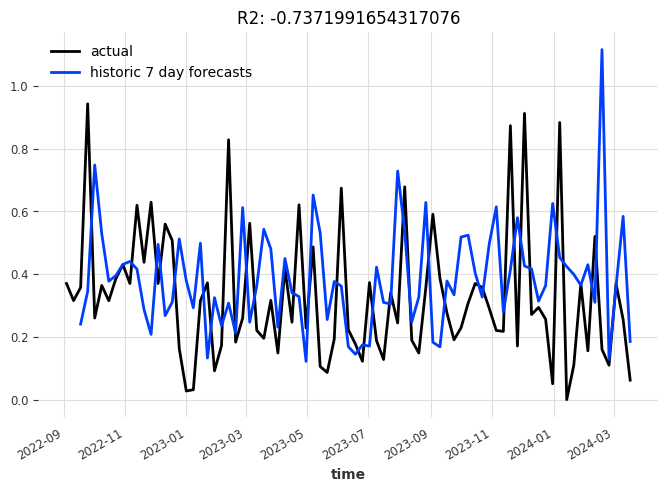

In [26]:
display_forecast(pred_series, data_, "7 day", start_date=hyperparametrizacion.split_value)

In [158]:
pred_series = model.historical_forecasts(
    data_,
    # start=pd.Timestamp("20230107"),
    start=pd.Timestamp(split_data),
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/126 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

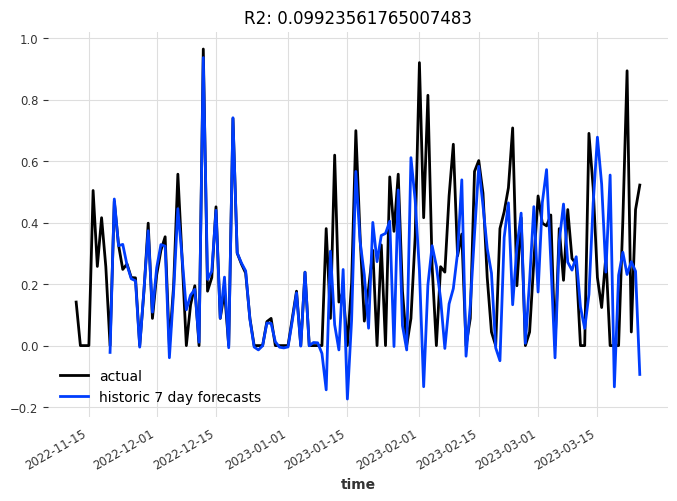

In [159]:
display_forecast(pred_series, data_, "7 day", start_date=pd.Timestamp(split_data))

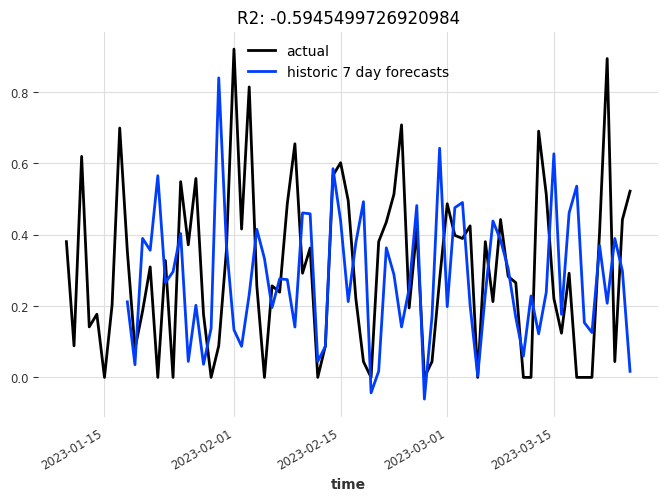

In [123]:
display_forecast(pred_series, data_, "7 day", start_date=pd.Timestamp(split_data))

In [21]:
# # data = data_for_process.dataframe.copy()
# data = filter_data.copy()
# data.reset_index(inplace=True)

# # data.plot(y='Cant Pedido UMV',x='Fecha Creación')

# #Llenado de espacion vacio o faltantes
# filler = MissingValuesFiller()
# data = filler.transform(
#     TimeSeries.from_dataframe(
#         data, "Fecha Creación", ["Cant Pedido UMV"]
#     )
# )

# #Separacion de datos para entrenamiento
# train, val = data.split_after(pd.Timestamp("20230107"))

# #Escalado de datos
# transformer = Scaler()
# train_transformed = transformer.fit_transform(train)
# val_transformed = transformer.transform(val)
# series_transformed = transformer.transform(data)

# #entrenamiento
# model_nbeats.fit(train, val_series=val, verbose=True)
#Predicciones sobre datos
# pred_series = model_nbeats.historical_forecasts(
#     data,
#     # series_transformed,
#     start=pd.Timestamp("20230107"),
#     forecast_horizon=10,
#     stride=1,
#     retrain=False,
#     verbose=True,
# )

In [124]:
split_data ='20221111'

In [125]:
pred_series = model_nbeats.historical_forecasts(
    data_,
    # series_transformed,
    start=pd.Timestamp(split_data),
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/126 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

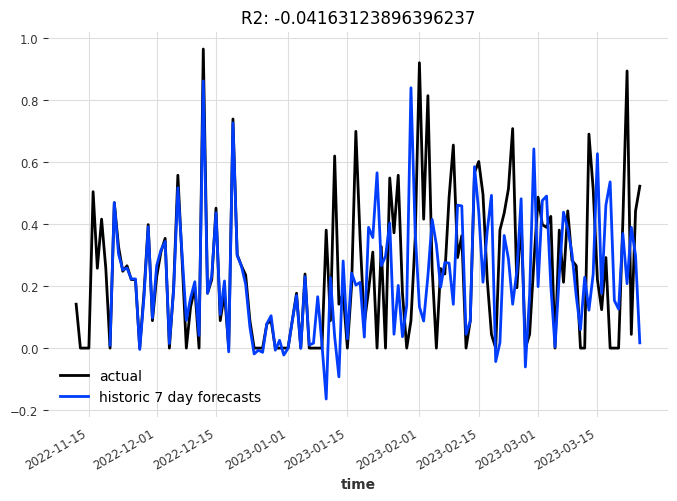

In [126]:
display_forecast(pred_series, data_, "7 day", start_date=pd.Timestamp(split_data))

In [22]:
invers_pred = scalesr.inverse_transform(pred_series)

In [23]:
data_frame_predicciones = invers_pred.pd_dataframe()

In [24]:
# data_frame_predicciones['varianza']abs
data_frame_predicciones['Varianza'] = data_frame_predicciones['Cant Pedido UMV'].pct_change() * 100

In [25]:
data_frame_predicciones

component,Cant Pedido UMV,Varianza
time,,
2023-01-16,402.994966,NaN
2023-01-17,434.945969,7.928388
2023-01-18,-22.591065,-105.193993
2023-01-19,132.718843,-687.483780
2023-01-20,342.239259,157.867875
...,...,...
2023-03-21,443.729884,84.847140
2023-03-22,244.781155,-44.835549
2023-03-23,338.851334,38.430319


In [16]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Calcula la varianza de la columna 'Valor'
df['varianza']= df['Valor'].expanding().var()

print("La varianza es: ", varianza)

La varianza es:  2.085147131696632


In [17]:
df

,Valor,varianza
2020-01-01,-0.546455,NaN
2020-01-02,-1.638226,0.595982
2020-01-03,1.104415,1.906570
2020-01-04,-0.389358,1.271261
2020-01-05,-0.433929,0.954330
...,...,...
2022-12-27,0.569679,1.005138
2022-12-28,0.149524,1.004252
2022-12-29,-0.770879,1.003815
2022-12-30,-1.459098,1.004724


In [7]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Selecciona el rango de fechas
df_subset = df.loc['2021-01-01':'2021-12-31']

# Calcula la varianza del subconjunto
varianza = df_subset['Valor'].var()

print("La varianza para el año 2021 es: ", varianza)


La varianza para el año 2021 es:  1.1026782047196244


In [10]:
df_subset

,Valor
2021-01-01,-0.380122
2021-01-02,0.047412
2021-01-03,0.650249
2021-01-04,-1.218616
2021-01-05,1.263046
...,...
2021-12-27,1.276249
2021-12-28,-0.362999
2021-12-29,1.667382
2021-12-30,-0.654364


In [11]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Calcula la diferencia entre cada fila y la siguiente
df['Diferencia'] = df['Valor'].diff()

# Elimina la primera fila, ya que su diferencia es NaN
df = df.dropna()

# Calcula la varianza de las diferencias
varianza = df['Diferencia'].var()

print("La varianza de las diferencias es: ", varianza)


La varianza de las diferencias es:  2.085147131696632


In [12]:
df

,Valor,Diferencia
2020-01-02,0.812481,0.920745
2020-01-03,-3.544196,-4.356677
2020-01-04,-0.366324,3.177872
2020-01-05,0.282619,0.648942
2020-01-06,-1.215430,-1.498049
...,...,...
2022-12-27,-1.113192,-2.274300
2022-12-28,-0.102095,1.011097
2022-12-29,-1.034648,-0.932553
2022-12-30,-1.764926,-0.730278


In [14]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Calcula la diferencia entre cada fila y la siguiente
df['Diferencia'] = df['Valor'].diff()

# Calcula la varianza de las diferencias hasta ese punto
df['Varianza'] = df['Valor'].expanding().var()

print(df.head())

               Valor  Diferencia  Varianza
2020-01-01  0.318880         NaN       NaN
2020-01-02  0.634320    0.315440  0.049751
2020-01-03  2.416640    1.782321  1.279461
2020-01-04 -1.418394   -3.835034  2.468000
2020-01-05  0.027293    1.445687  1.893425


In [18]:
import pandas as pd

# Creamos un DataFrame de ejemplo
df = pd.DataFrame({'Valores': [50, 75, 100, 125]})

# Calculamos la variación porcentual y multiplicamos por 100 para obtener el porcentaje
df['Varianza'] = df['Valores'].pct_change() * 100

print(df)

   Valores   Varianza
0       50        NaN
1       75  50.000000
2      100  33.333333
3      125  25.000000
